# Treino do zero (*from scratch*)

Neste script vamos conhecer a estratégia de treino tradicional de redes neurais em geral: **O treino do zero (*from scratch*)**. <br>
Trataremos do uso mais tradicional de CNNs: **classificação de imagens**.


Primeiro de tudo, vamos fazer os imports.

In [5]:
# Implementação e treinamento da rede
import torch
from torch import nn, optim

# Carregamento de Dados
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms


# Plots e análises
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import time, os



In [11]:
# Configurando hiperparâmetros.
args = {
    'epoch_num': 150,     # Número de épocas.
    'lr': 1e-3,           # Taxa de aprendizado.
    'weight_decay': 1e-3, # Penalidade L2 (Regularização).
    'batch_size': 50,     # Tamanho do batch.
}

# Definindo dispositivo de hardware
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


## Carregamento de Dados

Usaremos o dataset [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html), um conjunto de imagens RGB divididas em 10 categorias de objeto: avião, automóvel, pássaro, gato, veado, cachorro, sapo, cavalo, navio, caminhão. As imagens possuem $32 \times 32$ pixels.

Trata-se de um dataset de 60 mil imagens naturais (do mundo real), muito utilizado para avaliar a qualidade de modelos de aprendizado profundo.

https://pytorch.org/docs/stable/torchvision/datasets.html#cifar

In [6]:
data_transform = transforms.Compose([
                                     transforms.Resize(32),
                                     transforms.ToTensor(),])

train_set = datasets.CIFAR10('dados/', 
                      train=True, 
                      transform=data_transform, 
                      download=True)

test_set = datasets.CIFAR10('dados/', 
                      train=False, 
                      transform=data_transform, 
                      download=True)

Files already downloaded and verified
Files already downloaded and verified


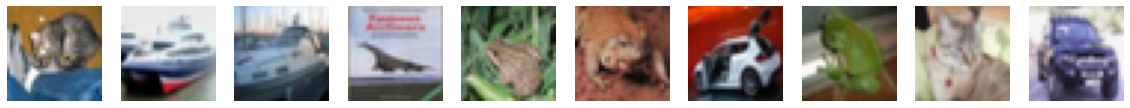

In [7]:
fig, axs = plt.subplots(1,10, figsize=(20, 2))
for i in range(10):
  data, label = test_set[i]
  axs[i].imshow(data.permute((1,2,0)))
  axs[i].axis('off')

In [10]:
train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True)

test_loader = DataLoader(test_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True)

## LeNet 5

Primeiro de tudo, precisamos **implementar uma CNN**. Sim, chegou a hora de colocar em prática tudo que já sabemos sobre redes convolucionais, montando uma arquitetura completa!

A arquitetura escolhida para essa aula é a LeNet. Ela é a primeira CNN bem sucedida da história, [proposta em 1998 pelo Yann LeCun](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). 

<img src="https://drive.google.com/uc?export=view&id=1BThCsFE8fSCe012klZmp8UpslOlzWsmK" width="800">

<img src="https://drive.google.com/uc?export=view&id=1oG_Jh8nA2Nrq8RTcIyJEOaIXXxa10Srw" width="700">

Vamos implementar blocos convolucionais incluindo todas as camadas que aprendemos nesse curso:
```python
net = nn.Sequential(
          nn.Conv2d(...),
          nn.BatchNorm2d(...),
          nn.Tanh(), # Ativação específica da LeNet
          nn.AvgPool2d(...), # Pooling específico da LeNet
      )
```

In [13]:
net = nn.Sequential(
        # Entrada (b, 3, 32, 32) saida (b, 6, 28,28)
        nn.Conv2d(3, 6, kernel_size = 5),
        nn.BatchNorm2d(6),
        nn.Tanh(), # Ativaçao especifica LeNet
        # Entrada (b, 6, 28, 28) saida (b, 6b 14,14)
        nn.AvgPool2d(kernel_size=2),

        # Entrada (b, 6, 14, 14) saida (b, 16, 10, 10)
        nn.Conv2d(6, 16, kernel_size = 5),
        nn.BatchNorm2d(16),
        nn.Tanh(), # Ativaçao especifica LeNet
        # Entrada (b, 16, 10, 10) saida (b, 16 5, 5)
        nn.AvgPool2d(kernel_size=2),

        # Entrada (b, 16, 5, 5) saida (b, 120, 1, 1)
        nn.Conv2d(16, 120, kernel_size = 5),
        nn.BatchNorm2d(120),
        nn.Tanh(), # Ativaçao especifica LeNet
        nn.Flatten(),

        # Entrada (b, N = 120*1*1)
        nn.Linear(120, 84),
        nn.Tanh(),
        # Entrada (b, 84) saida (b, 10)
        nn.Linear(84, 10)
)

net = net.to(args['device'])

print(net)


Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Tanh()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Tanh()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Tanh()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): Tanh()
  (14): Linear(in_features=84, out_features=10, bias=True)
)


VGG16

In [7]:
# # Definindo a rede
# net = nn.Sequential(
#         ## ConvBlock 1
#         nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),      # entrada: (b, 3, 224, 224) e saida: (b, 64, 224, 224)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 64, 224, 224) e saida: (b, 64, 112, 112)
        
#         ## ConvBlock 2
#         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),    # entrada: (b, 64, 112, 112) e saida: (b, 128, 112, 112)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 128, 112, 112) e saida: (b, 128, 56, 56)
        
#         ## ConvBlock 3
#         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),   # entrada: (b, 128, 56, 56) e saida: (b, 256, 56, 56)
#         nn.ReLU(),
#         nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),   # entrada: (b, 256, 56, 56) e saida: (b, 256, 56, 56)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 256, 56, 56) e saida: (b, 256, 28, 28)
        
#         ## ConvBlock 4
#         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 256, 28, 28) e saida: (b, 512, 28, 28)
#         nn.ReLU(),
#         nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 512, 28, 28) e saida: (b, 512, 28, 28)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 512, 28, 28) e saida: (b, 512, 14, 14)
        
#         ## ConvBlock 4
#         nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 512, 14, 14) e saida: (b, 512, 14, 14)
#         nn.ReLU(),
#         nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 512, 14, 14) e saida: (b, 512, 14, 14)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 512, 14, 14) e saida: (b, 512, 7, 7)
#         nn.Flatten(),  # lineariza formando um vetor               # entrada: (b, 512, 7, 7) e saida: (b, 512*7*7) = (b, 25088)
 
#         ## DenseBlock
#         nn.Linear(25088, 4096),                                    # entrada: (b, 25088) e saida: (b, 4096)
#         nn.ReLU(),
#         nn.Linear(4096, 4096),                                     # entrada: (b, 4096) e saida: (b, 4096)
#         nn.ReLU(),
#         nn.Linear(4096, 10),                                       # entrada: (b, 4096) e saida: (b, 10)
#         nn.Softmax(dim=-1)
#         )

# # Subindo no hardware de GPU (se disponível)
# net = net.to(args['device'])

## Do zero (From scratch)

O primeiro passo do treinamento do zero é definir os algoritmos que serão utilizados no processo de treinamento. Eles são:

* **Função de perda**, que vai avaliar a qualidade da performance da rede a cada passo de treinamento;
* **Otimizador**, que a partir da função de perda vai definir a melhor forma de atualizar os pesos.

In [15]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

Relembrando o passo a passo do fluxo de treinamento:

* Iterar nas épocas
* Iterar nos batches
* Cast dos dados no dispositivo de hardware
* Forward na rede e cálculo da loss
* Zerar o gradiente do otimizador
* Cálculo do gradiente e atualização dos pesos

Para acompanhar a convergência do seu modelo (e garantir que tudo foi feito certinho), ao final de cada época podemos imprimir a média e o desvio padrão das perdas de cada iteração.

In [16]:
def train(train_loader, net, epoch):

  # Training mode
  net.train()
  
  start = time.time()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  for batch in train_loader:
    
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    
    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)

    _, pred = torch.max(ypred, axis=1)
    pred_list.append(pred.cpu().numpy())
    rotulo_list.append(rotulo.cpu().numpy())
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)
  
  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  
  return epoch_loss.mean()
    

### Validação

Para essa etapa, o PyTorch oferece dois artifícios:
* ```model.eval()```: Impacta no *forward* da rede, informando as camadas caso seu comportamento mude entre fluxos (ex: dropout).
* ```with torch.no_grad()```: Gerenciador de contexto que desabilita o cálculo e armazenamento de gradientes (economia de tempo e memória). Todo o código de validação deve ser executado dentro desse contexto.

Exemplo de código para validação

```python
net.eval()
with torch.no_grad():
  for batch in test_loader:
      # Código de validação
```

Existe o equivalente ao ```model.eval()``` para explicitar que a sua rede deve estar em modo de treino, é o ```model.train()```. Apesar de ser o padrão dos modelos, é boa prática definir também o modo de treinamento.

In [17]:
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()
  
  start = time.time()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  with torch.no_grad(): 
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

      _, pred = torch.max(ypred, axis=1)
      pred_list.append(pred.cpu().numpy())
      rotulo_list.append(rotulo.cpu().numpy())

  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)
  
  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  
  return epoch_loss.mean()
    

In [18]:
train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):
  
  # Train
  train_losses.append(train(train_loader, net, epoch))
  
  # Validate
  test_losses.append(validate(test_loader, net, epoch))

#################### Train ####################
Epoch 0, Loss: 1.6629 +/- 0.1890, Acc: 40.89, Time: 18.15
********** Validate **********
Epoch 0, Loss: 1.5905 +/- 0.1526, Acc: 43.62, Time: 1.91

#################### Train ####################
Epoch 1, Loss: 1.4274 +/- 0.1554, Acc: 49.03, Time: 13.16
********** Validate **********
Epoch 1, Loss: 1.5158 +/- 0.1553, Acc: 47.25, Time: 1.65

#################### Train ####################
Epoch 2, Loss: 1.3514 +/- 0.1453, Acc: 51.61, Time: 15.10
********** Validate **********
Epoch 2, Loss: 1.3685 +/- 0.1522, Acc: 51.10, Time: 2.17

#################### Train ####################
Epoch 3, Loss: 1.3098 +/- 0.1514, Acc: 53.50, Time: 12.67
********** Validate **********
Epoch 3, Loss: 1.2821 +/- 0.1388, Acc: 54.36, Time: 1.51

#################### Train ####################
Epoch 4, Loss: 1.2733 +/- 0.1512, Acc: 54.96, Time: 11.89
********** Validate **********
Epoch 4, Loss: 1.3476 +/- 0.1642, Acc: 51.87, Time: 1.66

#################### Trai

KeyboardInterrupt: 